# Sentiment Analysis

In [121]:
# import the needed libraries
import pandas as pd
import requests
import os
import numpy as np

# libraries for preprocessing
from langdetect import detect, LangDetectException
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re 
import string
import preprocessor as p
import emoji
from emot.emo_unicode import EMOTICONS_EMO
from flashtext import KeywordProcessor

# libraries for build models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, TFBertModel
from joblib import dump, load
import torch
import tensorflow as tf

# import keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tkinter as tk
import customtkinter

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 1. Data Collection

## A. Gathering the Data

This section provides information on the data collection process using the web scraping library with Selenium [godkingjay/selenium-twitter-scraper](https://github.com/godkingjay/selenium-twitter-scraper) to gather tweets directly from twitter. We modified the code to get the tweets with emojis together. Modified code can be found in the repository below.

$ git clone https://github.com/dut0817/selenium-twitter-scraper.git

$ python scraper --tweets=1000

The data comprises of 1,000 tweets, with each row including the following fields:
* Name and Handle: User's name and Twitter id
* Timestamp: Date and time the tweet was posted.
* Verified: whether the twitter account is verified.
* <b>Content: Text of the tweet, including emojis.</b>
* Engagement metrics: number of comments, retweets, likes.
* Analytics: view count
* Tags and Mentions: lists of hashtags and other users mentioned in the tweet.
* Emojis: Emojis used in the tweet.
* Profile Image and Tweet Link: URLs to the user's profile image and the tweet itself.
* Tweet ID: Unique identifier for the tweet.


A few rows of the dataset can be seen below.

In [3]:
# Load our data from a CSV file, handling UTF-8 encoding issues
df_raw_data = pd.read_csv("./data/1000texts.csv", encoding='utf-8-sig')

# Display the first three rows of the dataframe to inspect the data
df_raw_data.head(3)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID
0,Binance,@binance,2024-04-03T00:00:06.000Z,True,The #Binance towel comes everywhere with me......,2.2K,589,2.1K,240K,['#Binance'],[],['\\U0001f373'],https://pbs.twimg.com/profile_images/174428939...,https://twitter.com/binance/status/17753122840...,tweet_id:1775312284052554156
1,Ash Crypto,@Ashcryptoreal,2024-04-04T00:24:48.000Z,True,Drop your $SOL address below and\r\nmake sure ...,2.2K,518,1.4K,104K,[],[],['\\U0001f447\\U0001f3fc'],https://pbs.twimg.com/profile_images/169999220...,https://twitter.com/Ashcryptoreal/status/17756...,tweet_id:1775680884982616105
2,Bitcoin,@Bitcoin,2024-04-03T03:19:33.000Z,True,"£52,356.70",156,141,767,161K,[],[],[],https://pbs.twimg.com/profile_images/421692600...,https://twitter.com/Bitcoin/status/17753624737...,tweet_id:1775362473790447725


## Annotating the Dataset

This section provides information on the sentiment annotation process using the `twitter-roberta-base-sentiment model` from Hugging Face. This process is crucial for labeling the data sentiment, preparing it for further analysis.

### Load and Prepare Data

In [3]:
# Load our data from a CSV file, handling UTF-8 encoding issues
df_raw_data = pd.read_csv("./data/1000texts.csv", encoding='utf-8-sig')

# Display the first three rows of the dataframe to inspect the data
df_raw_data.head(3)

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID
0,Binance,@binance,2024-04-03T00:00:06.000Z,True,The #Binance towel comes everywhere with me......,2.2K,589,2.1K,240K,['#Binance'],[],['\\U0001f373'],https://pbs.twimg.com/profile_images/174428939...,https://twitter.com/binance/status/17753122840...,tweet_id:1775312284052554156
1,Ash Crypto,@Ashcryptoreal,2024-04-04T00:24:48.000Z,True,Drop your $SOL address below and\r\nmake sure ...,2.2K,518,1.4K,104K,[],[],['\\U0001f447\\U0001f3fc'],https://pbs.twimg.com/profile_images/169999220...,https://twitter.com/Ashcryptoreal/status/17756...,tweet_id:1775680884982616105
2,Bitcoin,@Bitcoin,2024-04-03T03:19:33.000Z,True,"£52,356.70",156,141,767,161K,[],[],[],https://pbs.twimg.com/profile_images/421692600...,https://twitter.com/Bitcoin/status/17753624737...,tweet_id:1775362473790447725


We start by loading the dataset, ensuring that UTF-8 encoding is used to handle any special characters in the text. 

The initial peek at the data with `df.head(3)` helps to confirm the structure and data types we are working with.

### Data Cleaning

In [4]:
# Drop rows with any missing values
df_raw_data = df_raw_data.dropna()

# Convert the 'Content' column into a list of sentences
sentences = df_raw_data['Content'].tolist()

Next, we clean the data by removing rows with missing values to maintain the quality and consistency of our dataset. 

We extract the tweet content into a list to facilitate the subsequent batch processing.

### Model Details

For our annotation, we will be using [`twitter-roberta-base-sentiment`](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) model on huggingface.

This model is a RoBERTa-based neural network trained on approximately 58 million tweets and fine-tuned for sentiment analysis, making it highly adept at understanding the nuances of language used in tweets.

**Labels Explained**
- 0: Negative
- 1: Neutral
- 2: Positive

These labels correspond to the sentiment expressed in each tweet.

### API Configuration

In [5]:
# Group sentences into sub-lists of 10 for batch processing
grouped_list = [sentences[n:n+10] for n in range(0, len(sentences), 10)]

The api requires us to group the sentences for usage limitation.

### Set Up API for Annotation

In [19]:
# API token and endpoint for the annotation Hugging Face's model
API_TOKEN = "###"  # actual API token goes here
API_URL = "https://api-inference.huggingface.co/models/cardiffnlp/twitter-roberta-base-sentiment"
headers = {"Authorization": f"Bearer {API_TOKEN}"}  # Authorization header for the API request

We configure the API with the required endpoint and authentication details. We use the API_TOKEN gotten from Hugging Face.

### Annotation Execution

In [14]:
# Define a function to send data to the sentiment analysis API and get the response
def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [15]:
# Initialize an empty list to store outputs
query_output = []

# Loop through each group of sentences and perform sentiment analysis
for i in range(len(grouped_list)):
    query_output.append(query(grouped_list[i]))


We define a function to send each batch to the API and store the responses. Each response includes sentiment scores and labels for the batch of tweets processed.

### Understanding the Output

In [18]:
query_output[0]

[[{'label': 'LABEL_1', 'score': 0.6629162430763245},
  {'label': 'LABEL_2', 'score': 0.30983710289001465},
  {'label': 'LABEL_0', 'score': 0.02724670246243477}],
 [{'label': 'LABEL_1', 'score': 0.7137852907180786},
  {'label': 'LABEL_2', 'score': 0.22422194480895996},
  {'label': 'LABEL_0', 'score': 0.06199278309941292}],
 [{'label': 'LABEL_1', 'score': 0.7219901084899902},
  {'label': 'LABEL_0', 'score': 0.19005246460437775},
  {'label': 'LABEL_2', 'score': 0.08795742690563202}],
 [{'label': 'LABEL_2', 'score': 0.9080163240432739},
  {'label': 'LABEL_1', 'score': 0.08823398500680923},
  {'label': 'LABEL_0', 'score': 0.0037496844306588173}],
 [{'label': 'LABEL_2', 'score': 0.5220183730125427},
  {'label': 'LABEL_1', 'score': 0.3415689766407013},
  {'label': 'LABEL_0', 'score': 0.1364126354455948}],
 [{'label': 'LABEL_1', 'score': 0.5850756168365479},
  {'label': 'LABEL_0', 'score': 0.24756111204624176},
  {'label': 'LABEL_2', 'score': 0.16736333072185516}],
 [{'label': 'LABEL_0', 'scor

The output from the API provides a score for each sentiment category per tweet, indicating the confidence level of each sentiment prediction. This allows us to determine the most likely sentiment expressed in each tweet.

### Label Extraction and Assignment

In [20]:
# Initialize an empty list to hold the highest sentiment labels
highest_labels = []

# Extract the highest sentiment label from each result
for group in query_output:
    for result in group:
        highest = max(result, key=lambda x: x['score'])
        highest_labels.append(highest['label'].split('_')[1])

# Add the highest sentiment labels back to the dataframe
df_raw_data['label'] = highest_labels


After processing, we extract the highest scoring label for each tweet and add this label back into our DataFrame. This step converts the raw output into a practical annotation of the dataset.

### Saving the Results

In [21]:
# Define the final dataframe to be saved
df_data_final = df_raw_data[['Content', 'label']]

# Define the file path for the new CSV
file_path = os.path.join('data', 'labeled_texts_1000.csv')

# Save the dataframe to a CSV file, without the index, and handle UTF-8 encoding
#df_data_final.to_csv(file_path, index=False, encoding='utf-8-sig')

The fully annotated dataset is saved as a CSV file, preserving the original text alongside the newly assigned sentiment labels. This file can now be used for further analysis and training predictive models.

### Citation


Barbieri, F., Camacho-Collados, J., Espinosa Anke, L., & Neves, L. (2020). TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification. In Findings of the Association for Computational Linguistics: EMNLP 2020 (pp. 1644–1650). Association for Computational Linguistics.



# 2. Preprocessing

### Select only English tweets from data

In [164]:
# # language detection
# def detect_lang(text):
#    try:
#        return detect(text)
#    except LangDetectException:
#        return None

# df_texts_orig = pd.read_csv('data/labeled_texts_1000.csv', encoding='utf-8-sig')
# df_texts_orig.dropna(inplace=True)

# # detect language and add a new column
# df_texts_orig['lang'] = df_texts_orig['Content'].apply(detect_lang)

# # select only English texts
# df_eng = df_texts_orig[df_texts_orig['lang'] == 'en'].reset_index(drop=True)

# df_eng.to_csv('data/labeled_texts_eng.csv', index=False)

Annotated data was first filtered to only retain English tweets, as this uniformity is crucial for preprocessing and ensures that model training is conducted with a single language. The `langdetect` library was employed to identify these English tweets; however, since the detection results can vary slightly with each execution, the outcomes were saved to a CSV file to maintain consistency. This file is then loaded in subsequent steps for further use. Additionally, any entries without data were removed initially.

### Load Data

In [165]:
# Load the CSV file into a DataFrame
df_eng_loaded = pd.read_csv('data/labeled_texts_eng.csv')

# Extract the 'label' column from the DataFrame
df_labels = df_eng_loaded['label']

# Extract the 'Content' column from the DataFrame
df_texts = df_eng_loaded['Content']

# Create a list of texts by iterating over the DataFrame column 'df_texts'
texts = [text for text in df_texts]

# Print the first 5 elements of the 'texts' list
display(texts[:3])

# Return the total number of texts in the 'texts' list
len(texts)

['The #Binance towel comes everywhere with me...\r\n\r\nIncluding breakfast 🍳',
 'Drop your $SOL address below and\r\nmake sure you are following me\r\n\r\nDon’t ask why 👇🏼',
 'It only takes one good altcoin to change the world. ✨']

839

The saved English tweet data was loaded, and for future use, the labels were stored separately in a dataframe. Subsequently, each tweet was retrieved and stored in a list, with the resulting list consisting of strings as its elements.

### Text Preprocessing

#### Emoticon to Text Conversion Function

In [166]:
def convert_emoticons(text):
    # Set up a dictionary of emoticons
    all_emoji_emoticons = {**EMOTICONS_EMO}
    
    # Replace colons and underscores in keys with spaces, and trim spaces
    all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
    
    # Initialize a KeywordProcessor for replacing keywords
    kp_all_emoji_emoticons = KeywordProcessor()
    
    # Add each emoticon and its corresponding word to the KeywordProcessor
    for k, v in all_emoji_emoticons.items():
        kp_all_emoji_emoticons.add_keyword(k, v)
    
    # Replace all emoticons in the text with corresponding words
    return kp_all_emoji_emoticons.replace_keywords(text)

This function is designed to convert emoticons in text to their corresponding words. It initializes by merging dictionaries of emoticons and emojis into a comprehensive dictionary. After formatting the keys by replacing colons and underscores with spaces, it sets up a KeywordProcessor for efficient keyword replacement. Each emoticon and its corresponding word are then added to the processor, which substitutes emoticons in the text with words. 

#### Text Normalization Function

In [167]:
def normalize_text(text):
    # Replace 'fav' with 'favorite'
    text = re.sub(r'\bfav\b', "favorite", text)
    
    # Replace 'tkt' with 'ticket'
    text = re.sub(r'\btkt\b', "ticket", text)
    
    # Replace '(gm)' with 'good morning'
    text = re.sub(r'\(gm\)', 'good morning', text)
    
    # Replace '(r.i.p)' with 'rest in peace'
    text = re.sub(r'\(r.i.p\)', 'rest in peace', text)
    
    # Remove parenthetical references (typically credits like via or hat tips)
    text = re.sub(r'\([^)]*(via|h/t)[^)]*\)', '', text)
    
    # Reduce excess letter repetitions (more than two) to two
    text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)
    
    return text

This function normalizes text by replacing abbreviations with their full forms, converting expressions within parentheses, and removing any parenthetical references. It also limits excessive letter repetitions to two characters, streamlining the text for clarity and consistency.

#### Text Cleaning Function

In [168]:
def clean_characters(text, mode='default'):
    # Replace special characters (hyphens, underscores, colons) with a space
    cleaned_text = re.sub(r'[-_:]', ' ', text)

    # Normalize line endings, replacing carriage return and newline with just newline
    cleaned_text = re.sub(r'\r\n', '\n', cleaned_text)
    
    # Replace multiple consecutive newlines with a period followed by a space
    cleaned_text = re.sub(r'(\n)+', '. ', cleaned_text)
    
    # Reduce multiple consecutive dots to a single dot
    cleaned_text = re.sub(r'\.{2,}', '.', cleaned_text)
    
    # Reduce multiple consecutive question marks to a single one
    cleaned_text = re.sub(r'\?{2,}', '?', cleaned_text)

    # Remove characters that are not letters, numbers, basic punctuation, or newline
    cleaned_text = re.sub(r"[^a-zA-Z0-9 '.\n]", '', cleaned_text)

    if mode == 'default':
        # Remove periods at the end of each line or end of the text
        cleaned_text = re.sub(r'\.(?=\s|$)', '', cleaned_text)
        
        # Reduce multiple spaces to a single space
        cleaned_text = re.sub(r' {2,}', ' ', cleaned_text)
        
    elif mode == 'bert':
        # Clean up multiple spaces or periods into a single space or period
        cleaned_text = re.sub(r'\. \.', '. ', cleaned_text)
        
        # Reduce multiple spaces to a single space
        cleaned_text = re.sub(r' {2,}', ' ', cleaned_text)
    
    return cleaned_text.strip()

This function sanitizes text by replacing specific special characters with spaces and normalizing line endings. It also reduces repetitive punctuation and spaces, and removes non-essential characters to ensure clean and uniform text formatting. 

#### Tweet Cleaning Function

In [169]:
def get_wordnet_tag(tag):
    # Convert the NLTK POS tag to a WordNet POS tag
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    elif tag.startswith('V'):
        return 'v'
    else:
        return None

def clean_tweet(tweet, mode='default'):
    # Configure the preprocessor to remove URLs, mentions, and reserved words like RT or FAV
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
    
    # Clean the tweet using preprocessor settings
    cleaned_tweet = p.clean(tweet)

    # Convert all emojis in the tweet to text
    cleaned_tweet = emoji.demojize(cleaned_tweet)
    
    # Convert emoticons within the tweet to words
    cleaned_tweet = convert_emoticons(cleaned_tweet)
    
    # Normalize text to handle abbreviations and remove unnecessary parts
    normalized_text = normalize_text(cleaned_tweet.lower())

    # BERT Tokenizer
    if mode == 'bert' or mode == 'bert-direct':
        # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # if mode == 'bert-direct':
        #     encoded_input = tokenizer(normalized_text, return_tensors='tf', padding=True, truncation=True, max_length=512)
        #     return encoded_input
        # encoded_input = tokenizer.encode(normalized_text, add_special_tokens=True)
        # tokens = tokenizer.convert_ids_to_tokens(encoded_input)
        
        # Clean characters and correct formatting issues
        sentence_cleaned = clean_characters(normalized_text, mode='bert')
    
        return sentence_cleaned

    # Clean characters and correct formatting issues
    sentence_cleaned = clean_characters(normalized_text)
        
    # Tokenize the tweet
    tokens = word_tokenize(sentence_cleaned)
    
    # POS tagging
    pos_tagged = pos_tag(tokens)

    # Remove Stopwords
    stop_words_removed = [word for word in pos_tagged if word[0] not in stopwords.words('english')]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = [word if get_wordnet_tag(tag) is None else lemmatizer.lemmatize(word, get_wordnet_tag(tag)) for word, tag in stop_words_removed]
    
    return lemmatized_sentence

 This function first stripping away URLs, mentions, and reserved words. It then standardizes emojis and emoticons to text, and normalizes abbreviations and other text irregularities. It can optionally use the BERT tokenizer and then return for embedding with BERT, or proceed to clean the text, tokenize, remove stopwords, and apply lemmatization.

#### Multiple Tweet Cleaning Function

In [170]:
def get_cleaned_tweets(tweets, mode='default'):
    return [clean_tweet(tweet, mode) for tweet in tweets]

This function iterates through all tweets, calling the previously defined `clean_tweet` function for each one.

#### Clean All Tweets and Get Results

In [171]:
cleaned_tweets = get_cleaned_tweets(texts)
cleaned_tweets[:3]

[['binance', 'towel', 'come', 'everywhere', 'include', 'breakfast', 'cooking'],
 ['drop',
  'sol',
  'address',
  'make',
  'sure',
  'follow',
  'dont',
  'ask',
  'backhand',
  'index',
  'point',
  'medium',
  'light',
  'skin',
  'tone'],
 ['take', 'one', 'good', 'altcoin', 'change', 'world', 'sparkle']]

In [172]:
cleaned_tweets_bert = get_cleaned_tweets(texts, mode='bert')
cleaned_tweets_bert[:3]

['the binance towel comes everywhere with me. including breakfast cooking',
 'drop your sol address below and make sure you are following me dont ask why backhand index pointing down medium light skin tone',
 'it only takes one good altcoin to change the world. sparkles']

Call cleaning functions on all datasets, ensuring that each dataset undergoes the necessary preprocessing steps. Additionally, it performs cleaning tasks tailored for BERT processing on all datasets, preparing them for compatibility with BERT models.

### Save Preprocessing Output

In [173]:
# save dataframe as a CSV file
preprocessed_data = [' '.join(document) for document in cleaned_tweets]
df_preprocessed = pd.DataFrame(preprocessed_data, columns=['Content'])
df_preprocessed['Label'] = df_labels
df_preprocessed.to_csv('data/preprocessed_data.csv', index=False, encoding='utf-8-sig')

In [174]:
# save dataframe as a CSV file for BERT
df_preprocessed_bert = pd.DataFrame(cleaned_tweets_bert, columns=['Content'])
df_preprocessed_bert['Label'] = df_labels
df_preprocessed_bert.to_csv('data/preprocessed_data_bert.csv', index=False, encoding='utf-8-sig')

To facilitate further processing, each preprocessed tweet's tokens are concatenated into a string and stored in a dataframe along with the corresponding label for each dataset. These dataframes are then saved as CSV files locally. Since the BERT-specific data requires separate handling, it is saved in a distinct file.

### Load Preprocessing Outputs

In [175]:
# read the CSV file
df_preprocessed_loaded = pd.read_csv('data/preprocessed_data.csv', encoding='utf-8-sig')
print(df_preprocessed_loaded.head())

# read the CSV file
df_preprocssed_bert_loaded = pd.read_csv('data/preprocessed_data_bert.csv', encoding='utf-8-sig')
print(df_preprocssed_bert_loaded.head())

                                             Content  Label
0  binance towel come everywhere include breakfas...      1
1  drop sol address make sure follow dont ask bac...      1
2         take one good altcoin change world sparkle      2
3                   disrespectful one top 3 favorite      2
4  congressional republican call affordable conne...      1
                                             Content  Label
0  the binance towel comes everywhere with me. in...      1
1  drop your sol address below and make sure you ...      1
2  it only takes one good altcoin to change the w...      2
3          disrespectful is one of my top 3 favorite      2
4  some congressional republicans call the afford...      1


Verify that the preprocessed data saved as CSV files can be loaded back correctly by loading the CSV files.

# 3. Feature Extraction

### Read Preprocessed Data

In [176]:
# Read preprocessed data for BERT from a CSV file into a DataFrame using pandas
df_data = pd.read_csv('data/preprocessed_data.csv')

# Extract 'Content' column from the DataFrame and store it in the 'documents' variable
documents = df_data['Content']

# Extract 'Label' column from the DataFrame and store it in the 'labels' variable
labels = df_data['Label']

# Display the first few rows of the DataFrame to get a quick overview of the data
df_data.head()

,Content,Label
0,binance towel come everywhere include breakfas...,1
1,drop sol address make sure follow dont ask bac...,1
2,take one good altcoin change world sparkle,2
3,disrespectful one top 3 favorite,2
4,congressional republican call affordable conne...,1


Load the saved preprocessed data, then divide it into tweet data and labels, and store them in variables.

### Exploratory Data Analysis

In [177]:
# Create a new DataFrame from extracted 'documents' and 'labels', with column names 'text' and 'label'
data = pd.DataFrame({
    'text': documents,
    'label': labels
})

# Print the newly created DataFrame to display its contents
data.head()

,text,label
0,binance towel come everywhere include breakfas...,1
1,drop sol address make sure follow dont ask bac...,1
2,take one good altcoin change world sparkle,2
3,disrespectful one top 3 favorite,2
4,congressional republican call affordable conne...,1


combine documents and labels as one dataframe to create the wordcloud

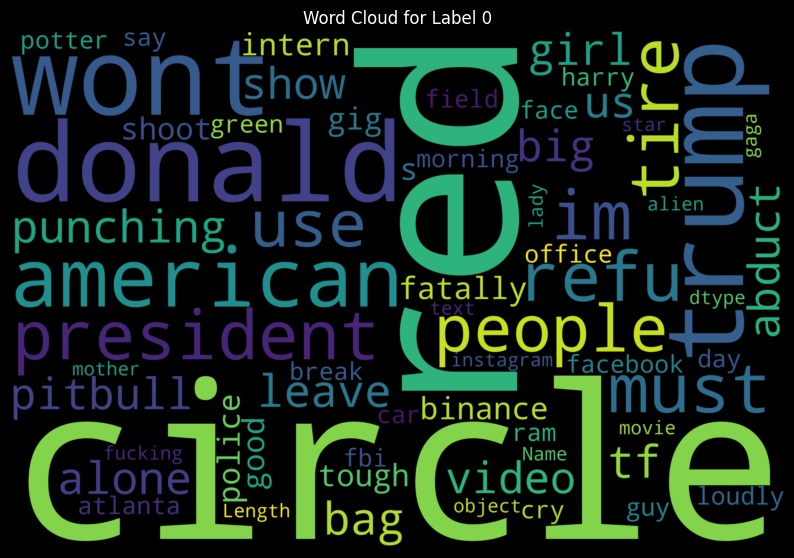

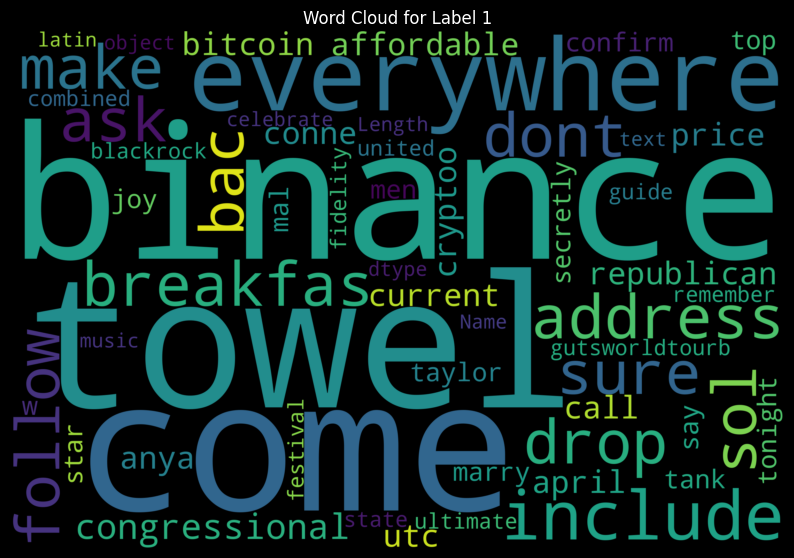

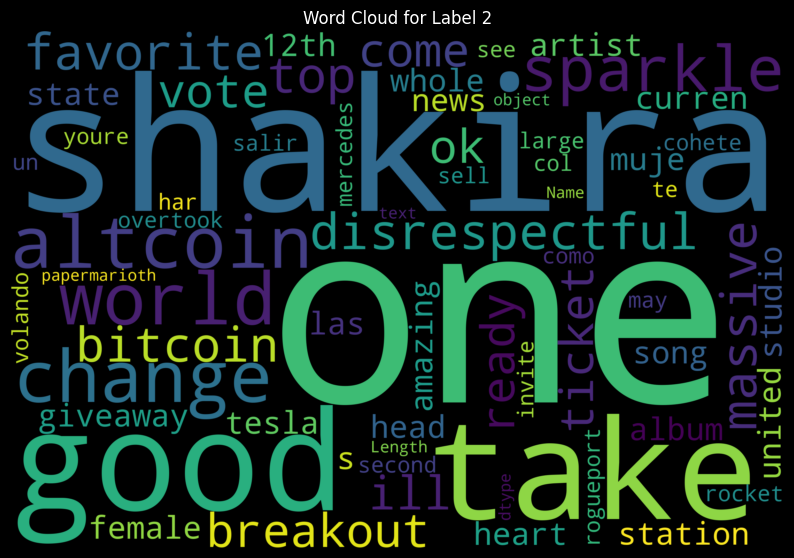

In [178]:
# Loop over each unique label in the 'label' column of the DataFrame, sorting them first
for label in sorted(data['label'].unique()):
    # Select texts corresponding to the current label and store in 'text'
    text = data[data['label'] == label]['text']

    # Create a WordCloud object with specified dimensions and settings, using the texts from the current label
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))

    # Set up a figure with specified dimensions and background/edge color
    fig = plt.figure(
        figsize = (10, 8),
        facecolor = 'k',
        edgecolor = 'k')
    # Display the generated WordCloud image, with bilinear interpolation for smoothness
    plt.imshow(wordcloud, interpolation = 'bilinear')
    # Set the title of the visualization with the current label, and set title color
    plt.title(f'Word Cloud for Label {label}', color='white')
    # Turn off the axis labels and ticks
    plt.axis('off')
    # Show the plot
    plt.show()


Use wordcloud to explore preprocessed data to figure out most frequently occuring words for each label and words associated with specific contexts or emotions for each label.

### Split Dataset

In [179]:
# Use the train_test_split function to split the documents and labels into training and testing sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2, random_state=42)

# Print the number of elements in the training dataset for documents
print("train data length: ", len(X_train))

# Print the number of elements in the testing dataset for documents
print("test data length: ", len(X_test))

# Print the number of elements in the training dataset for labels
print("train data label length: ", len(y_train))

# Print the number of elements in the testing dataset for labels
print("test data label length: ", len(y_test))

train data length:  671
test data length:  168
train data label length:  671
test data label length:  168


Split the dataset into training and testing sets for model traing.

## TF-IDF Vectorization

In [180]:
# Initialize a TfidfVectorizer object to convert text documents into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the training data and transform it into a TF-IDF-weighted document-term matrix
tfidf_matrix_train = vectorizer.fit_transform(X_train)

# Transform the testing data into a TF-IDF-weighted document-term matrix using the already fitted vectorizer
tfidf_matrix_test = vectorizer.transform(X_test)

# Print the TF-IDF matrix for the training data to see its structure and data type
print(tfidf_matrix_train)

  (0, 287)	0.37250219779291666
  (0, 2003)	0.3346270858732312
  (0, 1261)	0.23449073678596027
  (0, 1186)	0.21306868044902347
  (0, 1851)	0.2967519739535457
  (0, 933)	0.1944725173965879
  (0, 2757)	0.37250219779291666
  (0, 791)	0.37250219779291666
  (0, 2488)	0.3503466776092838
  (0, 306)	0.3503466776092838
  (1, 2050)	0.6017449021898648
  (1, 731)	0.5659545863075479
  (1, 1829)	0.3984962226458127
  (1, 1395)	0.3984962226458127
  (2, 1695)	0.427856938567264
  (2, 1511)	0.29354166402363363
  (2, 2234)	0.32684506390804846
  (2, 1061)	0.34923077040400946
  (2, 1062)	0.3103785037551525
  (2, 1186)	0.48946241853942346
  (2, 1851)	0.3408500455617201
  (2, 933)	0.2233716107496086
  (3, 620)	0.27548363383663
  (3, 169)	0.2156824053883861
  (3, 1078)	0.22118118289947156
  :	:
  (668, 1706)	0.336510799382073
  (668, 2662)	0.336510799382073
  (668, 578)	0.336510799382073
  (668, 216)	0.32141200519011487
  (668, 2385)	0.3001314500023342
  (668, 1401)	0.3001314500023342
  (668, 2512)	0.2920409584

Using the training dataset, create a TF-IDF matrix. Additionally, utilize the trained vectorizer to transform the test set into a TF-IDF matrix format.

## Word Embedding (Word2Vec)

#### Split data into tokens

In [181]:
# Tokenize each sentence in the training data into words using list comprehension and the split() method
train_tokenized = [[word for word in sentence.split()] for sentence in X_train]

# Tokenize each sentence in the testing data into words using list comprehension and the split() method
test_tokenized = [[word for word in sentence.split()] for sentence in X_test]

# Print the first three entries of the tokenized training data to verify the tokenization process
train_tokenized[:3]


[['barbie',
  'touch',
  'downn',
  'zany',
  'face',
  'pink',
  'heart',
  'im',
  'ready',
  'babes'],
 ['katy', 'perry', 'deserve', 'respect'],
 ['gagcitybaltimore',
  'gagcity',
  'smile',
  'face',
  'heart',
  'pink',
  'heart',
  'love',
  'nickiminaj']]

Tokenize the existing dataset to train a Word2Vec model and convert tokens into vector format.

#### Train Word2Vec model (skip-gram)

In [182]:
# Initialize and train a Skip-Gram Word2Vec model with specific parameters: vector size of 100, context window size of 5, 
# minimum count of words to consider set to 1, number of worker threads to 4, and using Skip-Gram training (sg=1)
model_skipGram = Word2Vec(sentences=train_tokenized, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Save the trained Word2Vec model to a binary file for later use or deployment
model_skipGram.save('model/modelSkipGram.bin')

Utilize the Word2Vec model for word embedding. Set the vector size to 100, window size to 5, and use the skip-gram model. Additionally, for future usability, save the trained skip-gram model locally.

In [183]:
# Load the pre-trained Skip-Gram Word2Vec model from a binary file
model_sg = Word2Vec.load('model/modelSkipGram.bin')

# Access the word vector for the word 'binance' from the word vectors of the loaded model
model_sg.wv['binance']

array([-0.00445902,  0.01634065, -0.00694207, -0.00438483,  0.00841007,
       -0.0122282 ,  0.01560146,  0.02137432,  0.00281858, -0.01503637,
       -0.00110781, -0.01888506,  0.00046454, -0.00904677, -0.00177177,
       -0.00321957, -0.00127397, -0.00705675, -0.00690071, -0.00512672,
        0.00035832,  0.00559705,  0.01083606, -0.00673679,  0.00461121,
        0.00367394, -0.01101265, -0.01190888, -0.01766353, -0.00350581,
        0.00612117,  0.01447187, -0.01335434, -0.00912677,  0.00399898,
        0.01932062, -0.01316629, -0.00678729, -0.01554591, -0.01363334,
        0.01360925, -0.00446401, -0.01233801, -0.00099011,  0.00692743,
       -0.00152671, -0.0014241 ,  0.00385705, -0.00923963,  0.01355584,
        0.00750908, -0.00633434, -0.00908377, -0.00489546, -0.01763797,
        0.01174945, -0.00062873,  0.0018901 , -0.00615397,  0.00089383,
        0.01231476, -0.00051145,  0.00167257,  0.0108922 , -0.0204607 ,
        0.00915872,  0.01578411,  0.00890062, -0.01402486,  0.01

Load the trained Word2Vec model from local storage and verify its functionality. You can confirm that each word is transformed into a 100-dimensional vector.

#### Convert all words to vectors

In [184]:
# Define a function to convert a tokenized sentence to a vector by averaging the word vectors
def convert_to_vector(model, tokenized_sentence):
    # Initialize an empty list to store the word vectors
    vector = []
    
    # Loop through each word in the tokenized sentence
    for word in tokenized_sentence:
        
        # Check if the word exists in the model's vocabulary
        if word in model.wv:
            # Append the word vector to the list
            vector.append(model.wv[word])
    
    # Compute the average of the word vectors if the list is not empty, otherwise return a zero vector of the same length as the model's vectors
    output = np.mean(vector, axis=0) if vector else np.zeros(model.vector_size)
    
    # Return the computed average vector or zero vector
    return output

# Convert each tokenized sentence in the training data into word vectors using the defined function and model
train_word_vectors = np.array([convert_to_vector(model_sg, sentence) for sentence in train_tokenized])

# Convert each tokenized sentence in the testing data into word vectors using the defined function and model
test_word_vectors = np.array([convert_to_vector(model_sg, sentence) for sentence in test_tokenized])

# Print the shape of the array containing the word vectors for the training data to check the dimensions
train_word_vectors.shape


(671, 100)

Utilize the trained Word2Vec model to convert the tokenized tweet data into vectors. Perform this transformation for both the training and testing datasets, and store them in array format.

## Contextual Embeddings Using BERT

This documentation provides a detailed guide to preprocessing text data and extracting contextual embeddings using the BERT model. This process enhances the representation of text for advanced NLP tasks

#### Load preprocessed data for BERT

In [185]:
# Read preprocessed data for BERT
df_data_bert = pd.read_csv('data/preprocessed_data_bert.csv')

In [186]:
# Extract content and labels into separate variables
X_bert = df_data_bert['Content']
y_bert = df_data_bert['Label']
X_bert.head()

0    the binance towel comes everywhere with me. in...
1    drop your sol address below and make sure you ...
2    it only takes one good altcoin to change the w...
3            disrespectful is one of my top 3 favorite
4    some congressional republicans call the afford...
Name: Content, dtype: object

Load the data saved for BERT embeddings from the preprocessing stage, then divide it into tweet data and labels to prepare for BERT embedding.

In [187]:
sentences_bert = X_bert.tolist()
sentences_bert[:3]

['the binance towel comes everywhere with me. including breakfast cooking',
 'drop your sol address below and make sure you are following me dont ask why backhand index pointing down medium light skin tone',
 'it only takes one good altcoin to change the world. sparkles']

### Add BERT Special Tokens

In [188]:
def add_special_tokens(sentence):
    # Step 1: Add the [CLS] token at the beginning of the sentence
    sentence_with_cls = "[CLS] " + sentence
    
    # Step 2: Add the [SEP] token at the end of the sentence
    sentence_with_sep = sentence_with_cls + " [SEP]"
    
    return sentence_with_sep

BERT requires specific tokens to be added to the text. This function inserts the [CLS] token at the start and the [SEP] token at sentence boundaries.

In [189]:
# Applying the function to all sentences in the results list
processed_results = [add_special_tokens(sentence) for sentence in sentences_bert]
processed_results[:3]

['[CLS] the binance towel comes everywhere with me. including breakfast cooking [SEP]',
 '[CLS] drop your sol address below and make sure you are following me dont ask why backhand index pointing down medium light skin tone [SEP]',
 '[CLS] it only takes one good altcoin to change the world. sparkles [SEP]']

#### Tokenization and Input Formatting

In [190]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all the processed results
tokenized_results = [tokenizer.tokenize(sentence) for sentence in processed_results]

# Convert tokens to their respective IDs in the BERT vocabulary
indexed_tokens_list = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_results]

Tokenize the preprocessed text and convert the tokens into indices that correspond to BERT's vocabulary.

### Prepare Model Inputs

### Create Segment IDs and Attention Masks

In [191]:
# Initialize lists for segment IDs and attention masks
token_type_list = []
attention_mask_list = []

# Generate segment IDs and attention masks for each sentence
for indexed_sentence in indexed_tokens_list:
    # For each sentence, all tokens belong to the same segment, so use 0
    segment_ids = [0] * len(indexed_sentence)
    token_type_list.append(segment_ids)
    
    # If you're not padding, all tokens are real, so the attention mask is all 1s
    attention_mask = [1] * len(indexed_sentence)
    attention_mask_list.append(attention_mask)


Segment IDs indicate to the model different segments of the input, while attention masks allow the model to ignore padding during processing.

#### Add Padding

In [192]:
# Maximum sequence length for BERT
max_bert_length = 512

# Initialize padded lists
padded_input_ids = []
padded_attention_mask = []

# Find the maximum sequence length in your batch (not exceeding BERT's limit)
max_length = min(max(len(tokens) for tokens in indexed_tokens_list), max_bert_length)

for tokens in indexed_tokens_list:
    # Truncate the tokens if they exceed the maximum length allowed by BERT
    truncated_tokens = tokens[:max_length]

    # Calculate the number of padding tokens needed
    num_padding_tokens = max_length - len(truncated_tokens)
    
    # Pad the truncated token IDs with zeros (assuming 0 is your padding token)
    padded_tokens = truncated_tokens + [0] * num_padding_tokens
    padded_input_ids.append(padded_tokens)
    
    # Pad the attention mask where actual tokens are marked with 1 and padding tokens with 0
    padded_mask = [1] * len(truncated_tokens) + [0] * num_padding_tokens
    padded_attention_mask.append(padded_mask)


Uniform input length is crucial for batch processing in neural networks. This step pads shorter sequences with zeros.

#### Extract Contextual Embeddings

This section describes loading the pre-trained BERT model, converting data into tensors, and running the model to extract contextual embeddings.

In [193]:
# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()  # Set the model to evaluation mode

# Convert the lists of integers into tensors
input_ids_tensor = torch.tensor(padded_input_ids)
attention_mask_tensor = torch.tensor(padded_attention_mask)

# Run the model and get the outputs
with torch.no_grad():
    outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
    hidden_states = outputs[2]  # Hidden states from all BERT layers
    word_embeddings = outputs.last_hidden_state  # The last layer's output
word_embeddings

tensor([[[-3.2154e-01,  1.0059e-01, -2.0366e-01,  ..., -1.5646e-01,
           3.3285e-01,  5.4474e-01],
         [-2.8895e-02, -1.0787e-01, -5.9481e-01,  ...,  2.6765e-01,
           3.0094e-01,  2.6721e-02],
         [ 1.7760e-01, -5.0432e-01,  5.3230e-01,  ..., -2.4333e-02,
          -2.2629e-01,  3.1017e-03],
         ...,
         [ 7.4847e-02,  6.7968e-02,  5.4264e-02,  ...,  1.9044e-01,
           8.1893e-02,  2.2637e-01],
         [ 5.3732e-02,  7.5114e-03,  1.0833e-01,  ...,  1.4244e-01,
           1.2260e-02,  9.7039e-02],
         [ 1.5107e-01, -6.0745e-02,  1.8311e-02,  ...,  5.3566e-02,
           1.3480e-01,  2.1442e-02]],

        [[-1.7777e-01, -2.3537e-02, -1.4073e-01,  ..., -6.9611e-01,
           2.6567e-01,  5.4172e-01],
         [ 6.5624e-01, -4.3236e-01,  3.4015e-01,  ...,  3.9572e-01,
           6.6239e-01, -7.2311e-01],
         [-1.6043e-01, -6.8251e-01, -5.9019e-02,  ..., -2.0564e-01,
           3.3378e-01, -3.2241e-01],
         ...,
         [-2.3574e-01, -6

In [194]:
# write the embeddings to a file
np.save('data/word_embeddings_tf.npy', word_embeddings)

# 4. Model Selection

## A. Classification Model for TF-IDF

#### Cross-validation with various classifiers on training dataset

This step involves initializing classifiers and performing cross-validation to assess their performance based on the training dataset transformed by TF-IDF.


In [195]:
# Initialize Support Vector Machine classifier with a linear kernel
clf_tfidf_svc = SVC(kernel='linear', random_state=42)

# Perform and print 5-fold cross-validation results
svm_scores = cross_val_score(clf_tfidf_svc, tfidf_matrix_train, y_train, cv=5)
print(f"SVM Cross-Validation Scores: {svm_scores}")



# Initialize Multinomial Naive Bayes classifier
clf_tfidf_nb = MultinomialNB()

# Perform and print 5-fold cross-validation results
nb_scores = cross_val_score(clf_tfidf_nb, tfidf_matrix_train, y_train, cv=5)
print(f"Naive Bayes Cross-Validation Scores: {nb_scores}")



# Initialize Random Forest classifier
clf_tfidf_rfc = RandomForestClassifier(random_state=42)

# Perform and print 5-fold cross-validation results
rfc_scores = cross_val_score(clf_tfidf_rfc, tfidf_matrix_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Scores: {rfc_scores}")


SVM Cross-Validation Scores: [0.71111111 0.70895522 0.67164179 0.67910448 0.64925373]
Naive Bayes Cross-Validation Scores: [0.68888889 0.64925373 0.62686567 0.64179104 0.60447761]
Random Forest Cross-Validation Scores: [0.62962963 0.6641791  0.64925373 0.6641791  0.64925373]


Cross-validation was performed on the training dataset using TF-IDF matrix-transformed data. Performance was measured for Support Vector Machine, Naive Bayes, and Random Forest Classifier algorithms. 

In [196]:
# Compute and print the mean of the cross-validation scores for SVM
svm_mean = np.mean(svm_scores)
print(f"SVM Cross-Validation Mean Score: {svm_mean}")

# Compute and print the mean of the cross-validation scores for Naive Bayes
nb_mean = np.mean(nb_scores)
print(f"Naive Bayes Cross-Validation Mean Score: {nb_mean}")

# Compute and print the mean of the cross-validation scores for Random Forest
rfc_mean = np.mean(rfc_scores)
print(f"Random Forest Cross-Validation Mean Score: {rfc_mean}")

SVM Cross-Validation Mean Score: 0.6840132669983416
Naive Bayes Cross-Validation Mean Score: 0.6422553897180763
Random Forest Cross-Validation Mean Score: 0.6512990602542841


On average, Support Vector Machine exhibited superior performance. Therefore, subsequent evaluation was conducted using SVM.
After performing 5-fold cross-validation on the training dataset with Support Vector Machine, it was observed that the accuracy scores for all folds ranged from approximately 0.65 to 0.71 and an average score of 0.68. This consistent performance indicates stable and satisfactory model performance.

#### Train and Save the Best Classifier

#### Train the classifier and get the performance on test set

In [197]:
# Train the SVM model on the entire training dataset
clf_tfidf_svc.fit(tfidf_matrix_train, y_train)

# Save the trained model to a file
dump(clf_tfidf_svc, 'model/svc_tfidf.joblib')

['model/svc_tfidf.joblib']

In [198]:
# Load the trained SVM model from the file
loaded_tfidf_model = load('model/svc_tfidf.joblib')

# Predict on the test dataset
y_pred_tfidf_svc = loaded_tfidf_model.predict(tfidf_matrix_test)

# Calculate and print the accuracy of the model on the test dataset
test_accuracy = accuracy_score(y_test, y_pred_tfidf_svc)
print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 0.6547619047619048


The SVM classifier was trained using the transformed TF-IDF matrix derived from the tweet data in the training dataset. Subsequently, predictions were made on the test set, yielding an accuracy of 0.65. This accuracy is slightly lower than the scores observed during cross-validation on training dataset.

#### Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.33      0.46        27
           1       0.65      0.85      0.74        91
           2       0.63      0.48      0.55        50

    accuracy                           0.65       168
   macro avg       0.68      0.55      0.58       168
weighted avg       0.66      0.65      0.64       168



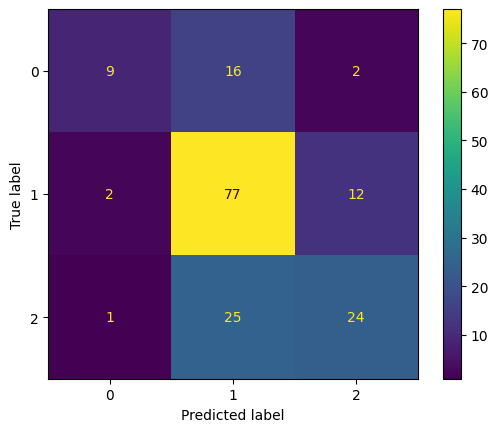

In [199]:
# Generate and display the confusion matrix
cm_tfidf_svc = confusion_matrix(y_test, y_pred_tfidf_svc)
conf_matrix_display = ConfusionMatrixDisplay(cm_tfidf_svc, display_labels=clf_tfidf_svc.classes_)
conf_matrix_display.plot()

# Generate and print the classification report to get precision, recall, and F1-score
report_tfidf_svc = classification_report(y_test, y_pred_tfidf_svc)
print("Classification Report:\n", report_tfidf_svc)

The model's precision, recall, F1-score values for each predicted class, along with the confusion matrix, were displayed. From a precision perspective, the performance in identifying Class 0 (Positive) was the best, while Class 2 (Negative) exhibited the lowest performance. Considering the F1-score, which incorporates recall as well, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) demonstrated the least favorable performance.

## B. Classification Models for Word2Vec

#### Cross-validation with various classifiers on training dataset

This step involves initializing classifiers and performing cross-validation to assess their performance based on the training dataset transformed by Word2Vec.


In [200]:
# Initialize a Support Vector Machine with a linear kernel
clf_emb_svc = SVC(kernel='linear', random_state=42)

# Perform 5-fold cross-validation and store the results
svm_emb_scores = cross_val_score(clf_emb_svc, train_word_vectors, y_train, cv=5)

# Print the cross-validation results for SVM
print(f"SVM: {svm_emb_scores}")


# Initialize a Decision Tree classifier with a maximum depth of 5
clf_emb_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# Perform 5-fold cross-validation and store the results
dt_emb_scores = cross_val_score(clf_emb_dt, train_word_vectors, y_train, cv=5)

# Print the cross-validation results for Decision Tree
print(f"DT: {dt_emb_scores}")



# Initialize a Random Forest Classifier
clf_emb_rfc = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation and store the results
rfc_emb_scores = cross_val_score(clf_emb_rfc, train_word_vectors, y_train, cv=5)

# Print the cross-validation results for Random Forest
print(f"RFC: {rfc_emb_scores}")


SVM: [0.5037037  0.51492537 0.51492537 0.50746269 0.50746269]
DT: [0.51851852 0.47761194 0.52238806 0.47761194 0.53731343]


RFC: [0.63703704 0.65671642 0.64179104 0.61940299 0.63432836]


In [201]:
# Compute and print the mean of the cross-validation scores for SVM
svm_emb_mean = np.mean(svm_emb_scores)
print(f"SVM Cross-Validation Mean Score: {svm_emb_mean}")

# Compute and print the mean of the cross-validation scores for Decision Trees
dt_emb_mean = np.mean(dt_emb_scores)
print(f"Decision Tree Cross-Validation Mean Score: {dt_emb_mean}")

# Compute and print the mean of the cross-validation scores for Random Forest
rfc_emb_mean = np.mean(rfc_emb_scores)
print(f"Random Forest Cross-Validation Mean Score: {rfc_emb_mean}")

SVM Cross-Validation Mean Score: 0.5096959646213378
Decision Tree Cross-Validation Mean Score: 0.5066887783305694
Random Forest Cross-Validation Mean Score: 0.6378551686014372


After performing classification using Support Vector Machine, Decision Tree, and Random Forest algorithms on data embedded with Word2Vec, it was observed that Random Forest yielded the best performance. Therefore, the Random Forest Classifier model has been selected for further evaluation and analysis. After conducting 5-fold cross-validation with Random Forest Classifier, it was observed that similar performance was achieved across all folds. The scores, measured in accuracy, range consistently between 0.62 and 0.65 across all folds.

#### Train the classifier and get the performance on test set

In [202]:
# train the model
clf_emb_rfc.fit(train_word_vectors, y_train)

# save the model
dump(clf_emb_rfc, 'model/rfc_emb.joblib')

['model/rfc_emb.joblib']

In [203]:
# Load the trained RFC model from the file
loaded_emb_model = load('model/rfc_emb.joblib')

# Predict on the test dataset
y_pred_emb_rfc = loaded_emb_model.predict(test_word_vectors)

# Calculate and print the accuracy of the model on the test dataset
emb_test_accuracy = accuracy_score(y_test, y_pred_emb_rfc)
print(f"Test Set Accuracy: {emb_test_accuracy}")

Test Set Accuracy: 0.6547619047619048


The Random Forest Classifier was trained on the vectorized training dataset. Subsequently, predictions were made on the test set, and the accuracy score was computed. The accuracy on the test set is approximately 0.65.

#### Evaluation

              precision    recall  f1-score   support

           0       0.56      0.19      0.28        27
           1       0.65      0.90      0.76        91
           2       0.70      0.46      0.55        50

    accuracy                           0.65       168
   macro avg       0.63      0.52      0.53       168
weighted avg       0.65      0.65      0.62       168



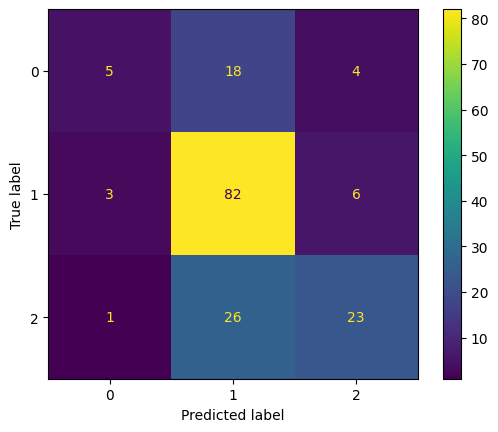

In [204]:
# Generate and display the confusion matrix
cm_emb_rfc = confusion_matrix(y_test, y_pred_emb_rfc)
conf_matrix_display = ConfusionMatrixDisplay(cm_emb_rfc, display_labels=clf_emb_rfc.classes_)
conf_matrix_display.plot()


# Generate and print the classification report to get precision, recall, and F1-score
report_emb_rfc = classification_report(y_test, y_pred_emb_rfc)
print(report_emb_rfc)

The model's precision, recall, F1-score values for each predicted class, along with the confusion matrix, were displayed. From a precision perspective, the performance in identifying Class 2 (Positive) was the best, while Class 0 (Negative) exhibited the lowest performance. Considering the F1-score, which incorporates recall as well, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) demonstrated the least favorable performance.

## C. Clasficiation Models for BERT

Exploring models for classifying BERT-embedded data involves evaluating Support Vector Machine, Simple Deep Neural Network, and LSTM models. The performance of each model will be assessed, and the best-performing model will be selected.

In [205]:
# read the embeddings from a file
word_embeddings = np.load('data/word_embeddings_tf.npy')
print(word_embeddings.shape)
word_embeddings

(839, 88, 768)


array([[[-3.21544468e-01,  1.00585140e-01, -2.03661591e-01, ...,
         -1.56456113e-01,  3.32846254e-01,  5.44741571e-01],
        [-2.88947783e-02, -1.07873015e-01, -5.94808817e-01, ...,
          2.67654836e-01,  3.00939739e-01,  2.67208423e-02],
        [ 1.77596405e-01, -5.04317403e-01,  5.32303512e-01, ...,
         -2.43333112e-02, -2.26288199e-01,  3.10166553e-03],
        ...,
        [ 7.48473033e-02,  6.79676309e-02,  5.42635508e-02, ...,
          1.90440997e-01,  8.18932801e-02,  2.26366743e-01],
        [ 5.37324212e-02,  7.51139782e-03,  1.08331487e-01, ...,
          1.42442822e-01,  1.22603532e-02,  9.70387980e-02],
        [ 1.51073679e-01, -6.07451200e-02,  1.83109250e-02, ...,
          5.35655692e-02,  1.34799033e-01,  2.14423258e-02]],

       [[-1.77768037e-01, -2.35367287e-02, -1.40733361e-01, ...,
         -6.96109951e-01,  2.65668452e-01,  5.41716516e-01],
        [ 6.56243503e-01, -4.32362854e-01,  3.40148091e-01, ...,
          3.95723999e-01,  6.62394762e

In the previous step, the data embedded using a pretrained BERT model is loaded. This data contains the hidden states of each token.

### Support Vector Machine

BERT outputs a vector for each token in the text. To use these vectors in traditional classifiers like SVM, we need a single vector per text sample. Averaging is a simple yet effective way to reduce a matrix of embeddings into a single vector that captures the essence of all tokens in the text. This method maintains significant contextual information while simplifying the input for the SVM.

In [206]:
# Average the word embeddings for each text sample
X_bert_avg = word_embeddings.mean(axis=1)

Each tweet's embedding value needs to be input into the model, but BERT's output consists of hidden states for multiple tokens. Therefore, the average of these embedding values was calculated and used as the input value for the model.

In [207]:
# Split data into training and testing sets
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert_avg, y_bert, test_size=0.2, random_state=42)

The averaged embedding values, along with their corresponding labels, were split into training and test sets.

In [208]:
# Initialize the SVM with RBF kernel and set regularization (C=10) and kernel coefficient (gamma=0.01)
clf_bert_svc = SVC(C=10, gamma=0.01, kernel='rbf')

# Perform 5-fold cross-validation and store the results
svm_bert_scores = cross_val_score(clf_bert_svc, X_train_bert, y_train_bert, cv=5)

# Print the cross-validation results for SVM
print(f"SVM: {svm_bert_scores}")

SVM: [0.75555556 0.79850746 0.75373134 0.79850746 0.76119403]


Support Vector Machine was used to perform 5-fold cross-validation on the training dataset. While there were variations in performance across folds, the performance ranged between approximately 0.7 and 0.79, indicating good performance overall.

In [209]:
# train the model
clf_bert_svc.fit(X_train_bert, y_train_bert)

# save the model
dump(clf_bert_svc, 'model/svc_bert.joblib')

['model/svc_bert.joblib']

In [210]:
# load the model
loaded_bert_model = load('model/svc_bert.joblib')

# predict on the test set
y_pred_bert_svc = loaded_bert_model.predict(X_test_bert)

# Calculate accuracy
accuracy_bert_svc = accuracy_score(y_test_bert, y_pred_bert_svc)
print("Accuracy:", accuracy_bert_svc)

Accuracy: 0.7619047619047619


The SVM model was trained on the training dataset. Subsequently, predictions were made on the test set, resulting in an accuracy score of 0.78. This indicates a fairly good performance.

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66        27
           1       0.82      0.77      0.80        91
           2       0.78      0.76      0.77        50

    accuracy                           0.76       168
   macro avg       0.73      0.76      0.74       168
weighted avg       0.77      0.76      0.76       168



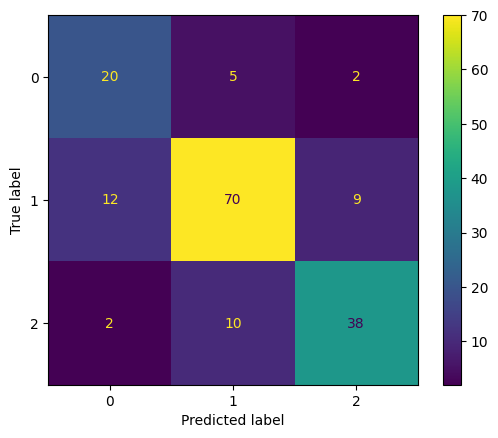

In [211]:
# Confusion matrix
cm_bert_svc = confusion_matrix(y_test_bert, y_pred_bert_svc)
conf_matrix_display = ConfusionMatrixDisplay(cm_bert_svc, display_labels=clf_bert_svc.classes_)
conf_matrix_display.plot()

# Detailed classification report
class_report = classification_report(y_test_bert, y_pred_bert_svc)
print("Classification Report:\n", class_report)

The model's precision, recall, F1-score values for each predicted class, along with the confusion matrix, were displayed. From a precision perspective, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) exhibited the lowest performance. Considering the F1-score, which incorporates recall as well, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) demonstrated the least favorable performance. Overall score is higher than other models.

### Simple DNN

#### Extract CLS embeddings

In [212]:
cls_embeddings = word_embeddings[:, 0, :]
print(cls_embeddings.shape)
cls_embeddings

(839, 768)


array([[-0.32154447,  0.10058514, -0.20366159, ..., -0.15645611,
         0.33284625,  0.5447416 ],
       [-0.17776804, -0.02353673, -0.14073336, ..., -0.69610995,
         0.26566845,  0.5417165 ],
       [-0.03118031,  0.09259857, -0.15223485, ..., -0.43219727,
         0.42710632,  0.36966813],
       ...,
       [-0.6632388 ,  0.13981363, -0.39583886, ..., -0.6768938 ,
         0.35785115,  0.73756415],
       [-0.2074437 , -0.02013526,  0.08991455, ..., -0.58624315,
         0.4439776 ,  0.3415959 ],
       [-0.14089474,  0.2844081 , -0.4900113 , ..., -0.18643233,
         0.16744328,  0.18638492]], dtype=float32)

When performing BERT embedding, the embedding value of the first token, known as the CLS embedding, contains information about the entire sentence. Therefore, this time, we will extract only the first output from the BERT word_embedding output for each sentence and use it as the dataset.

#### Split Dataset

In [213]:
# Split data into training, validation, and testing sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(cls_embeddings, y_bert, test_size=0.2, random_state=42)
X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(X_train_cls, y_train_cls, test_size=0.2, random_state=42)

The entire dataset containing CLS embeddings is split into training and test datasets. Additionally, a validation set is split for model evaluation during training the model.

#### Construct DNN Model

In [214]:
# Initialize a sequential DNN model
model_dnn = Sequential()

# Add a dense layer with 64 neurons, ReLU activation, and input dimension of 768 (BERT embeddings dimension)
model_dnn.add(Dense(64, activation='relu', input_dim=768))

# Add a dropout layer to prevent overfitting by randomly setting input units to 0 with a rate of 0.5 during training
model_dnn.add(Dropout(0.5))

# Add a final dense layer with 3 output nodes for 3 classes, using softmax activation for multi-class classification
model_dnn.add(Dense(3, activation='softmax'))

# Compile the model specifying the optimizer, loss function, and metrics to track
optimizer = Adam(learning_rate=0.0001)  # Initialize the Adam optimizer with a learning rate of 0.0001

model_dnn.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
                  metrics=['accuracy'])  # Track accuracy during training

# Set up a model checkpoint to save the model with the best validation loss during training
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/best_model_dnn.hdf5',  # File path where the model will be saved
    save_weights_only=False,  # Save the entire model, not just the weights
    monitor='val_loss',  # Monitor validation loss to determine the best model
    mode='min',  # Save the model when the monitored value reaches its minimum
    save_best_only=True)  # Only save the model when it is the "best"

# Print the model summary to check the architecture
model_dnn.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                49216     
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 49,411
Trainable params: 49,411
Non-trainable params: 0
_________________________________________________________________


A simple deep neural network for classification using CLS embeddings as input is implemented. Each layer consists of a Dense layer with 64 outputs, dropout, followed by another Dense layer outputting 3 classes. The first layer uses ReLU activation function, while the last layer uses softmax. Adam optimizer is used with an initial learning rate of 0.0001, and sparse_categorical_crossentropy is used as the loss function. The ModelCheckPoint callback is utilized to save the model when the validation dataset's loss is minimized, selecting it as the best model.

#### Train Model

In [215]:
model_dnn.fit(X_train_cls, 
              y_train_cls, 
              epochs=150, 
              batch_size=16,
              validation_data=(X_val_cls, y_val_cls),
              callbacks=[model_checkpoint_callback])

Epoch 1/150


34/34 [==============================] - 1s 11ms/step - loss: 1.1971 - accuracy: 0.3619 - val_loss: 1.0190 - val_accuracy: 0.4815
Epoch 2/150
34/34 [==============================] - 0s 6ms/step - loss: 1.0728 - accuracy: 0.4981 - val_loss: 0.9909 - val_accuracy: 0.5037
Epoch 3/150
34/34 [==============================] - 0s 6ms/step - loss: 1.0281 - accuracy: 0.4981 - val_loss: 0.9650 - val_accuracy: 0.4963
Epoch 4/150
34/34 [==============================] - 0s 8ms/step - loss: 0.9804 - accuracy: 0.5261 - val_loss: 0.9473 - val_accuracy: 0.5111
Epoch 5/150
34/34 [==============================] - 0s 8ms/step - loss: 0.9319 - accuracy: 0.5560 - val_loss: 0.9313 - val_accuracy: 0.5185
Epoch 6/150
34/34 [==============================] - 0s 9ms/step - loss: 0.8855 - accuracy: 0.6045 - val_loss: 0.9065 - val_accuracy: 0.5481
Epoch 7/150
34/34 [==============================] - 0s 8ms/step - loss: 0.8898 - accuracy: 0.5877 - val_loss: 0.8907 - val_accuracy: 0.5630
Epoch 8/150
34/34 [=====

The training was conducted for a total of 150 epochs with a batch size of 16 on the training dataset. The best model is saved when the loss value on the validation data is minimized.

#### Load the Best Model

In [216]:
best_model_dnn = load_model('model/best_model_dnn.hdf5') 

The best-performing model saved during training is loaded and used to predict the test set.

#### Prediction

In [217]:
# Evaluate the model on the test set
y_pred_bert_dnn = best_model_dnn.predict(X_test_cls)

# Convert the predicted probabilities to class labels
y_pred_dnn_class = y_pred_bert_dnn.argmax(axis=1)

6/6 [==============================] - 0s 3ms/step


Using the best model, predictions are made on the test set. Since the predicted values are probabilities for each class, the class with the highest probability is selected as the predicted class.

#### Evaluation

              precision    recall  f1-score   support

           0       0.59      0.70      0.64        27
           1       0.72      0.75      0.73        91
           2       0.73      0.60      0.66        50

    accuracy                           0.70       168
   macro avg       0.68      0.68      0.68       168
weighted avg       0.70      0.70      0.70       168



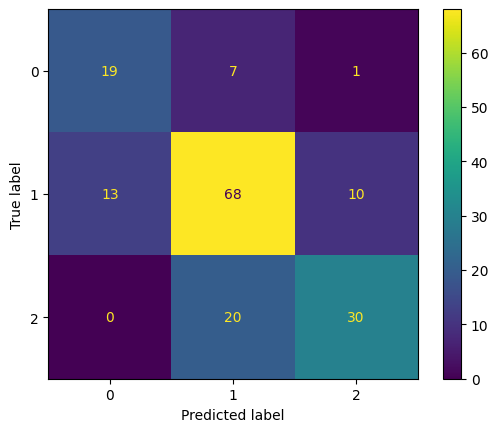

In [218]:
# Confusion matrix
cm_bert_dnn = confusion_matrix(y_test_cls, y_pred_dnn_class)
conf_matrix_display = ConfusionMatrixDisplay(cm_bert_dnn, display_labels=clf_bert_svc.classes_)
conf_matrix_display.plot()

print(classification_report(y_test_cls, y_pred_dnn_class))


The model's precision, recall, F1-score values for each predicted class, along with the confusion matrix, were displayed. From a precision perspective, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) exhibited the lowest performance. Considering the F1-score, which incorporates recall as well, the performance in identifying Class 1 (Neutral) was the best, while Class 0 (Negative) demonstrated the least favorable performance. Overall, scores are similar but slightly lower to the SVM model.

### LSTM

In [219]:
# Assuming 'y' contains integer labels for categories
y_train_encoded = to_categorical(y_train_bert)
y_test_encoded = to_categorical(y_test_bert)

In [220]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(word_embeddings, y_bert, test_size=0.2, random_state=42)

In [221]:
# Determine the number of unique classes from the encoded training labels
num_classes = y_train_encoded.shape[1]

# Initialize a Sequential model and add an LSTM layer, a dropout layer, and a dense output layer
model_lstm = Sequential([
    # LSTM layer with 100 units; input shape expected to be [timesteps, features] from word embeddings
    LSTM(100, input_shape=(word_embeddings.shape[1], word_embeddings.shape[2])),
    # Dropout layer to reduce overfitting by omitting features during training with a dropout rate of 20%
    Dropout(0.2),
    # Dense output layer with a number of neurons equal to the number of classes, using softmax for probability distribution across multiple classes
    Dense(num_classes, activation='softmax')
])

# List of callbacks, includes model checkpointing to save the model that achieves the best performance on validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/best-lstm.keras",  # Path where the model will be saved
      save_best_only=True,  # Save only when the monitored metric (validation loss) has improved
      monitor="val_loss"  # Monitor validation loss during training
    )
]

# Compile the model with categorical crossentropy as the loss function (appropriate for multi-class classification),
# Adam optimizer (a popular choice that adjusts learning rate dynamically), and track accuracy during training
model_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print a summary of the model to get detailed information about the model's architecture, including the number of trainable parameters
model_lstm.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               347600    
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 303       
                                                                 
Total params: 347,903
Trainable params: 347,903
Non-trainable params: 0
_________________________________________________________________


In [222]:
history = model_lstm.fit(X_train_lstm, y_train_encoded,  # Use one-hot encoded labels
                    epochs=150,  # May need adjustment
                    batch_size=32,  # May need adjustment
                    validation_split=0.2,
                    callbacks=callbacks
                    )  # Fraction of data to use as validation


Epoch 1/150


17/17 [==============================] - 3s 76ms/step - loss: 0.8965 - accuracy: 0.5821 - val_loss: 0.7543 - val_accuracy: 0.6296
Epoch 2/150
17/17 [==============================] - 0s 28ms/step - loss: 0.5416 - accuracy: 0.7929 - val_loss: 0.7877 - val_accuracy: 0.6370
Epoch 3/150
17/17 [==============================] - 0s 27ms/step - loss: 0.3668 - accuracy: 0.8601 - val_loss: 0.8126 - val_accuracy: 0.6815
Epoch 4/150
17/17 [==============================] - 1s 32ms/step - loss: 0.2503 - accuracy: 0.9198 - val_loss: 0.6905 - val_accuracy: 0.7111
Epoch 5/150
17/17 [==============================] - 0s 26ms/step - loss: 0.1285 - accuracy: 0.9608 - val_loss: 0.8810 - val_accuracy: 0.7630
Epoch 6/150
17/17 [==============================] - 0s 27ms/step - loss: 0.1029 - accuracy: 0.9683 - val_loss: 0.8529 - val_accuracy: 0.7111
Epoch 7/150
17/17 [==============================] - 0s 25ms/step - loss: 0.2019 - accuracy: 0.9310 - val_loss: 0.8232 - val_accuracy: 0.7259
Epoch 8/150
17/17 

#### Load the Best Model

In [223]:
best_lstm_model = load_model('./models/best-lstm.keras')

The best-performing model saved during training is loaded and used to predict the test set.

#### Prediction

In [224]:
test_loss, test_acc = best_lstm_model.evaluate(X_test_lstm, y_test_encoded)
print('Test Accuracy:', test_acc)

# Evaluate the model on the test set
y_pred_bert_lstm = best_lstm_model.predict(X_test_lstm)

# Convert the predicted probabilities to class labels
y_pred_lstm_class = y_pred_bert_lstm.argmax(axis=1)

y_test_lstm = np.argmax(y_test_encoded, axis=1)


6/6 [==============================] - 0s 13ms/step - loss: 0.8250 - accuracy: 0.6905
Test Accuracy: 0.6904761791229248
6/6 [==============================] - 0s 10ms/step


Using the best model, predictions are made on the test set. Since the predicted values are probabilities for each class, the class with the highest probability is selected as the predicted class.

#### Evaluation

              precision    recall  f1-score   support

           0       0.55      0.67      0.60        27
           1       0.79      0.67      0.73        91
           2       0.64      0.74      0.69        50

    accuracy                           0.69       168
   macro avg       0.66      0.69      0.67       168
weighted avg       0.71      0.69      0.69       168



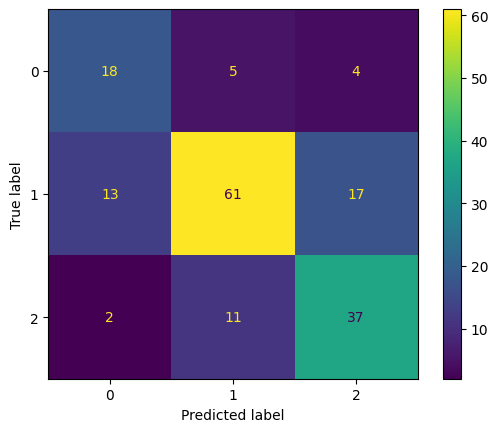

In [225]:
# Confusion matrix
cm_bert_lstm = confusion_matrix(y_test_lstm, y_pred_lstm_class)
conf_matrix_display = ConfusionMatrixDisplay(cm_bert_lstm, display_labels=[0, 1, 2])
conf_matrix_display.plot()

print(classification_report(y_test_lstm, y_pred_lstm_class))


## 5. Deployment and Interface

In [257]:
# load model for prediction
predict_model = load('model/old_svc_bert.joblib')

app = customtkinter.CTk()
app.title("Custom Tkinter")
app.geometry("820x480")

app.grid_columnconfigure((0), weight=1)
# app.grid_columnconfigure((1), weight=1)
app.grid_columnconfigure((2), weight=1)
app.grid_columnconfigure((3), weight=1)

In [258]:
textbox = customtkinter.CTkTextbox(app, wrap="word", corner_radius=15)

textbox.insert("0.0", "What is on you mind?")  # insert at line 0 character 0

textbox.grid(row=0, column=0, columnspan=4, padx=50, sticky="nsew", pady=10)

In [259]:
sentiment = customtkinter.CTkTextbox(app, width=400, height=100, wrap="word", corner_radius=15)

sentiment.insert("0.0", "The emotion here is giving...")  # insert at line 0 character 0
text_sentiment = sentiment.get("0.0", "end")  # get text from line 0 character 0 till the end
# textbox.delete("0.0", "end")  # delete all text
sentiment.configure(state="disabled")  # configure textbox to be read-only

sentiment.grid(row=3, column=2, pady=10)

In [261]:
# Load pre-trained model tokenizer (vocabulary) and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()  # Set the model to evaluation mode

def get_bert_embeddings(sentence, mode='svc'):
    cleaned_sentence = clean_tweet(sentence, mode='bert')

    # Step 1: Add special tokens
    sentence_with_special_tokens = "[CLS] " + cleaned_sentence + " [SEP]"
        
    # Step 2: Tokenize and convert to input IDs
    tokenized_text = tokenizer.tokenize(sentence_with_special_tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    # Step 3: Padding/truncation to max length 512
    max_length = 512
    attention_mask = [1] * len(input_ids)  # Create an attention mask
    if len(input_ids) > max_length:
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
    else:
        padding = [0] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding
    
    # Convert lists to tensors
    input_ids_tensor = torch.tensor([input_ids])  # Add batch dimension
    attention_mask_tensor = torch.tensor([attention_mask])  # Add batch dimension
    
    # Step 4: Run the model and get the outputs
    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
        embedding = outputs.last_hidden_state  # The last layer's output
    
    if mode == 'svc':
        return embedding.mean(axis=1)
    return embedding


In [263]:
def button_callback():
    input_text = textbox.get("0.0", "end")  # get text from line 0 character 0 till the end
    embedding_output = get_bert_embeddings(input_text)
    output_pred = predict_model.predict(embedding_output)

    if output_pred == 0:
        output_text = "Negative"
    elif output_pred == 1:
        output_text = "Neutral"
    else:
        output_text = "Positive"

    sentiment.configure(state="normal")
    sentiment.delete("0.0", "end")
    sentiment.insert("0.0", output_text)
    sentiment.configure(state="disabled")


In [264]:
button = customtkinter.CTkButton(app, text="PREDICT", width=200, height=30, command=button_callback, fg_color="#f40e7d", hover_color="#d4116f", corner_radius=15, font=("Arial", 12))
button.grid(row=1, column=2, pady=4)

In [265]:
app.mainloop()

we hope to see you on board ben happy face or smiley
button clicked
we hope to see you on board ben happy face or smiley
button clicked
we hope to see you on board ben happy face or smiley
button clicked
hope to see you on board ben happy face or smiley
button clicked
hope to see you
button clicked
hope to see you on
button clicked
hope to see you on board
button clicked


Example Tweets for Test

- unfortunately boarding is a total nightmare as there is an ID error on my booking and I cannot checkin. Useless.
- We hope to see you on board, Ben! :)
- Ok, @KLM get me on a flight to the great American eclipse then. @AmericanEclipse 😁
- Can I only opt in at point of reservation? Can't find how to opt-in for existing reservation.